In [243]:
import os
import time
import datetime

os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # disable GPU

import pandas as pd
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import pandas_datareader.data as web
import numpy as np

# visuals.
import seaborn as sns
import matplotlib.pyplot as plt

# processing / validation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# keras/tf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout

# models
from sklearn import svm
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import tree
from sklearn.ensemble import VotingRegressor

# metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# constant seed for reproducibility
SEED = 111 
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# cpu workers
WORKERS = 6 

In [218]:
tickers = ["BTC-USD", "^DJI", "^GSPC", "MSFT", "AAPL", "AMZN", "FB", "GOOGL", "JPM", "JNJ", "V", "MA", "INTC"]
DAYS = 365
YEARS = 2

df_raw = pd.DataFrame() 
attempt = 0
drop = []
while len(tickers) != 0 and attempt <= 5:
    tickers = [j for j in tickers if j not in drop] 
    for i in range(len(tickers)):
        try:
            temp = web.get_data_yahoo(tickers[i],datetime.date.today() - datetime.timedelta(DAYS * YEARS), # reduce delta
                                      datetime.date.today())
            
            temp.dropna(inplace = True)
            df_raw[tickers[i]] = temp["Adj Close"]
            drop.append(tickers[i])       
        except:
            print(tickers[i]," :failed to fetch data...retrying")
            continue
    attempt+=1
    
df_raw.tail()

,BTC-USD,^DJI,^GSPC,MSFT,AAPL,AMZN,FB,GOOGL,JPM,JNJ,V,MA,INTC
Date,,,,,,,,,,,,,
2020-04-05,7271.781250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-06,7176.414551,22679.990234,2663.679932,165.270004,262.470001,1997.589966,165.550003,1183.189941,89.459999,139.759995,169.440002,265.529419,58.430000
2020-04-07,7334.098633,22653.859375,2659.409912,163.490005,259.429993,2011.599976,168.830002,1182.560059,90.639999,137.479996,168.589996,258.679993,58.400002
2020-04-08,7302.089355,23433.570312,2749.979980,165.130005,266.070007,2043.000000,174.279999,1207.000000,94.300003,143.259995,174.940002,270.950012,58.980000
2020-04-11,6811.986328,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [219]:
# missing values

# BTC market is open all the time whereas Stock and Index markets are closed on weekends.
# drop missing values caused by this behvaiour
print(df_raw.isnull().sum())

df = df_raw.dropna()

BTC-USD      0
^DJI       228
^GSPC      228
MSFT       228
AAPL       228
AMZN       228
FB         228
GOOGL      228
JPM        228
JNJ        228
V          228
MA         228
INTC       228
dtype: int64


In [220]:
# percent change dataframe
df_pct = pd.DataFrame()
for col in df.columns:
    df_pct[col] = df[col].pct_change()
df_pct.dropna(inplace=True)

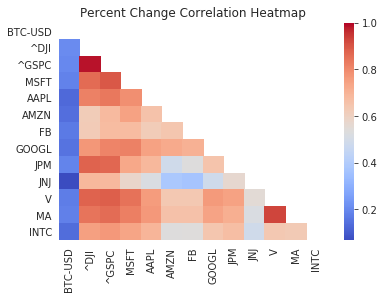

In [221]:
# plt.figure(figsize=(15,7))
corr = df_pct.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax1 = sns.heatmap(corr, mask=mask, square=False,cmap="coolwarm").set_title("Percent Change Correlation Heatmap")

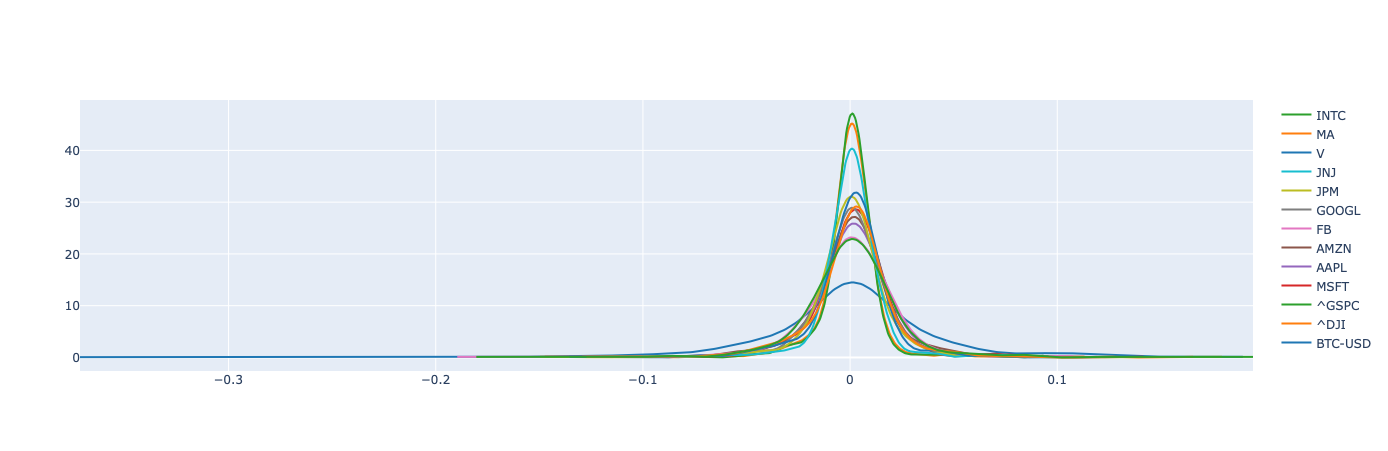

In [222]:
import plotly.figure_factory as ff
import numpy as np
import pandas as pd

fig = ff.create_distplot([df_pct[c] for c in df_pct.columns], df_pct.columns, show_rug=False, show_hist=False)
fig.show()

In [ ]:
# import plotly.graph_objects as go
# from plotly.subplots import make_subplots

# fig = make_subplots(rows=13, cols=1, start_cell="bottom-left",     subplot_titles=df.columns,shared_xaxes=True)

# i, j = 1, 1
# for col in df.columns:
#     fig.add_trace(go.Scatter(x=df.index, y=df[col],name=col), row=i, col=1)
#     if j != 4: i += 1
#     else:
#         i += 1
#         j = 1

# fig.update_layout(
#     title=f' Daily Chart',
#     xaxis_title='Date',
#     yaxis_title='Price ($)',
# #     xaxis=dict(position=1)
# #     template="plotly_dark",
# )
# fig.update_layout(
#     autosize=True,
# #      width=1500,
#     height=2000,
#     margin=dict(
#         l=50,
#         r=50,
#         b=100,
#         t=100,
#         pad=4
#     ),
# #     paper_bgcolor="LightSteelBlue",
# )

# fig.show()

In [276]:
SEQ_LEN = 3
TARGET = "AAPL"

# percent change dataframe
df_pct = pd.DataFrame()
for col in df.columns:
    df_pct[col] = df[col].pct_change()
df_pct.dropna(inplace=True)

# get percent change of previous days
for col in df_pct.drop(TARGET, axis=1).columns:
    for i in range(1,SEQ_LEN+1):
        df_pct[f"{col}_t-{i}"] = df_pct[col].shift(i)
df_pct.dropna(inplace=True)

# labeling
df_pct[f"{TARGET}_Future"] = df[TARGET].shift(-1)
df_pct.dropna(inplace=True)
df_pct[f"{TARGET}_Price"] = df[TARGET]
df_pct = df_pct.drop(TARGET, 1)

In [277]:
df_pct

,BTC-USD,^DJI,^GSPC,MSFT,AMZN,FB,GOOGL,JPM,JNJ,V,MA,INTC,BTC-USD_t-1,BTC-USD_t-2,BTC-USD_t-3,^DJI_t-1,^DJI_t-2,^DJI_t-3,^GSPC_t-1,^GSPC_t-2,^GSPC_t-3,MSFT_t-1,MSFT_t-2,MSFT_t-3,AMZN_t-1,AMZN_t-2,AMZN_t-3,FB_t-1,FB_t-2,FB_t-3,GOOGL_t-1,GOOGL_t-2,GOOGL_t-3,JPM_t-1,JPM_t-2,JPM_t-3,JNJ_t-1,JNJ_t-2,JNJ_t-3,V_t-1,V_t-2,V_t-3,MA_t-1,MA_t-2,MA_t-3,INTC_t-1,INTC_t-2,INTC_t-3,AAPL_Future,AAPL_Price
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-04-18,0.016034,-0.001556,0.000831,0.003851,0.015966,-0.013637,-0.003678,-0.008075,-0.021603,0.005493,0.006280,0.001307,0.033071,-0.010537,0.011434,0.008692,0.008740,-0.005020,0.010662,0.008109,-0.002887,0.020176,0.011710,-0.005343,0.043240,0.007485,-0.012226,0.023236,0.001884,0.003967,0.031794,0.009710,-0.001205,0.000000,-0.000816,-0.027080,-0.009259,0.008728,0.001457,0.015753,0.009358,-0.002643,0.025709,-0.002295,-0.003032,0.021756,0.010413,-0.016313,168.009125,172.909393
2018-04-19,0.066494,-0.003361,-0.005726,-0.003422,0.019027,0.010459,0.013074,0.021954,-0.001331,-0.004178,-0.002508,-0.025928,0.016034,0.033071,-0.010537,-0.001556,0.008692,0.008740,0.000831,0.010662,0.008109,0.003851,0.020176,0.011710,0.015966,0.043240,0.007485,-0.013637,0.023236,0.001884,-0.003678,0.031794,0.009710,-0.008075,0.000000,-0.000816,-0.021603,-0.009259,0.008728,0.005493,0.015753,0.009358,0.006280,0.025709,-0.002295,0.001307,0.021756,0.010413,161.125412,168.009125
2018-04-20,0.005624,-0.008188,-0.008537,-0.011549,-0.018896,-0.010827,-0.011134,-0.002238,-0.006978,0.001936,-0.010781,-0.013213,0.066494,0.016034,0.033071,-0.003361,-0.001556,0.008692,-0.005726,0.000831,0.010662,-0.003422,0.003851,0.020176,0.019027,0.015966,0.043240,0.010459,-0.013637,0.023236,0.013074,-0.003678,0.031794,0.021954,-0.008075,0.000000,-0.001331,-0.021603,-0.009259,-0.004178,0.005493,0.015753,-0.002508,0.006280,0.025709,-0.025928,0.001307,0.021756,160.658752,161.125412
2018-04-23,0.090148,-0.000583,0.000056,0.003684,-0.006304,-0.002646,-0.003258,-0.004844,0.001342,0.002093,-0.009318,-0.008345,0.005624,0.066494,0.016034,-0.008188,-0.003361,-0.001556,-0.008537,-0.005726,0.000831,-0.011549,-0.003422,0.003851,-0.018896,0.019027,0.015966,-0.010827,0.010459,-0.013637,-0.011134,0.013074,-0.003678,-0.002238,0.021954,-0.008075,-0.006978,-0.001331,-0.021603,0.001936,-0.004178,0.005493,-0.010781,-0.002508,0.006280,-0.013213,-0.025928,0.001307,158.422516,160.658752
2018-04-24,-0.087833,-0.017365,-0.013381,-0.023387,-0.038060,-0.037084,-0.047653,-0.004688,-0.005046,-0.025631,-0.012483,0.006849,0.090148,0.005624,0.066494,-0.000583,-0.008188,-0.003361,0.000056,-0.008537,-0.005726,0.003684,-0.011549,-0.003422,-0.006304,-0.018896,0.019027,-0.002646,-0.010827,0.010459,-0.003258,-0.011134,0.013074,-0.004844,-0.002238,0.021954,0.001342,-0.006978,-0.001331,0.002093,0.001936,-0.004178,-0.009318,-0.010781,-0.002508,-0.008345,-0.013213,-0.025928,159.112808,158.422516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-01,0.028281,-0.044424,-0.044142,-0.035508,-0.021552,-0.043165,-0.051508,-0.062979,-0.017692,-0.049714,-0.053610,-0.041389,0.026113,-0.004815,-0.036722,-0.018377,0.031923,-0.040590,-0.016013,0.033516,-0.033687,-0.015727,0.070341,-0.041061,-0.007246,0.033603,-0.028325,0.005122,0.058422,-0.040100,0.013644,0.032470,-0.045283,-0.037112,0.026007,-0.071239,-0.014134,0.079977,-0.026942,-0.026877,0.024821,-0.043344,-0.046160,0.022613,-0.059009,-0.024689,0.059576,-0.057076,244.929993,240.910004
2020-04-02,-0.008867,0.022438,0.022829,0.020709,0.005834,-0.008835,0.013547,0.037340,0.033693,0.027954,0.044924,0.047610,0.028281,0.026113,-0.004815,-0.044424,-0.018377,0.031923,-0.044142,-0.016013,0.033516,-0.035508,-0.015727,0.070341,-0.021552,-0.007246,0.033603,-0.043165,0.005122,0.058422,-0.051508,0.013644,0.032470,-0.062979,-0.037112,0.026007,-0.017692,-0.014134,0.079977,-0.049714,-0.026877,0.0248

In [266]:
X = df_pct.drop(f"{TARGET}_Future", axis=1).values
y = df_pct[f"{TARGET}_Future"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=SEED)
print(f"X_train shape:{X_train.shape}")

X_train shape:(248, 50)


In [269]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

dnnReg = Sequential()

dnnReg.add(Dense(100, activation="relu"))
dnnReg.add(Dense(100, activation="relu"))

dnnReg.add(Dense(100, activation="relu"))

dnnReg.add(Dense(100, activation="relu"))

dnnReg.add(Dense(100, activation="relu"))

dnnReg.add(Dense(100, activation="relu"))

dnnReg.add(Dense(100, activation="relu"))

dnnReg.add(Dense(100, activation="relu"))

dnnReg.add(Dense(100, activation="relu"))




dnnReg.add(Dense(1))

dnnReg.compile(optimizer="adam", loss="mse")

In [270]:
dnnReg.fit(x=X_train, y=y_train, epochs=1000,validation_data=(X_test,y_test),use_multiprocessing=True, workers=WORKERS)
pd.DataFrame(dnnReg.history.history).plot()

Train on 248 samples, validate on 249 samples
Epoch 1/1000
248/248 [==============================] - 2s 9ms/sample - loss: 46048.4321 - val_loss: 35282.4011
Epoch 2/1000
248/248 [==============================] - 0s 667us/sample - loss: 19901.2847 - val_loss: 4564.9390
Epoch 3/1000
248/248 [==============================] - 0s 671us/sample - loss: 4237.8176 - val_loss: 2693.6170
Epoch 4/1000
248/248 [==============================] - 0s 735us/sample - loss: 2459.0835 - val_loss: 27.1194
Epoch 5/1000
248/248 [==============================] - 0s 662us/sample - loss: 716.3467 - val_loss: 48.7561
Epoch 6/1000
248/248 [==============================] - 0s 675us/sample - loss: 358.7294 - val_loss: 51.4318
Epoch 7/1000
248/248 [==============================] - 0s 619us/sample - loss: 144.5117 - val_loss: 27.2144
Epoch 8/1000
248/248 [==============================] - 0s 610us/sample - loss: 76.6993 - val_loss: 34.3750
Epoch 9/1000
248/248 [==============================] - 0s 637us/sample 

KeyboardInterrupt: 

In [257]:
dnnPreds = dnnReg.predict(X_test)
print(mean_squared_error(y_test, dnnPreds))
print(r2_score(y_test, dnnPreds))

2167.5776419826984
-0.28867732416094394


In [278]:
svmReg = svm.SVR(kernel='linear').fit(X_train, y_train)
svmPreds = svmReg.predict(X_test)
print(mean_squared_error(y_test, svmPreds))
print(r2_score(y_test, svmPreds))

25.04612840693961
0.9851094710007606


In [273]:
gboostReg = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.01, max_depth=1,  loss='ls', random_state=SEED).fit(X_train, y_train)
gboostPredds = gboostReg.predict(X_test)
print(mean_squared_error(y_test, gboostPredds))
print(r2_score(y_test, gboostPredds))

30.162581362907968
0.9820676159932226


In [274]:
dtReg = tree.DecisionTreeRegressor(random_state=SEED).fit(X_train, y_train)
dtPredds = dtReg.predict(X_test)
print(mean_squared_error(y_test, dtPredds))
print(r2_score(y_test, dtPredds))

49.70490612121613
0.9704492313551595


In [275]:
ensReg = VotingRegressor(estimators=
                         [
                             ('svmReg', svmReg),
                             ('gboost', gboostReg),
                             ('dtReg', dtReg)
                         ]
                        ).fit(X_train, y_train)
print(mean_squared_error(y_test, ensReg.predict(X_test)))
print(r2_score(y_test, ensReg.predict(X_test)))

28.754517800474225
0.9829047438306484
